<a href="https://colab.research.google.com/github/NeoLux-Inc/StyleGAN3/blob/main/StyleGAN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#%cd /content/drive/MyDrive/StyleGAN3

In [1]:
#!pip install imgui
#!pip install glfw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.7 MB/s eta 0:00:0000:0100:01
DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Obtaining dependency information for glfw from https://files.pythonhosted.org/packages/fe/d2/1c4b83561898d6c642ae2dd3d118288bf06ba2afea3c56bad6ffd907a8a0/glfw-2.6.2-py2.py27.py3.py30.py31.py32.py33.py34.py35.py36.py37.py38-none-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 2.7 MB/s eta 0:00:0000:01
DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 23.3 will enforce this behaviour change. A possible replace

In [ ]:
#!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
#!echo "Shinji0923" | sudo -S unzip ninja-linux.zip -d /usr/local/bin/
#!echo "Shinji0923" | sudo -S update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force 

In [37]:
#%cd ..
#!git clone https://github.com/adamian98/pulse.git
#%cd StyleGAN3

'/home/kawa/AI/GitHub_public/StyleGAN3'

In [12]:
!python ../pulse/align_face.py -input_dir inputs/img -output_dir inputs/align -output_size 1024 -seed 12

dst.jpg: Number of faces detected: 1
src.jpg: Number of faces detected: 1


In [13]:
import cv2
import numpy as np
from PIL import Image
import dlib
from matplotlib import pyplot as plt
import torch
import dnnlib
import legacy
import imageio
from tqdm.notebook import tqdm

from moviepy.video.fx.resize import resize
from moviepy.editor import VideoFileClip

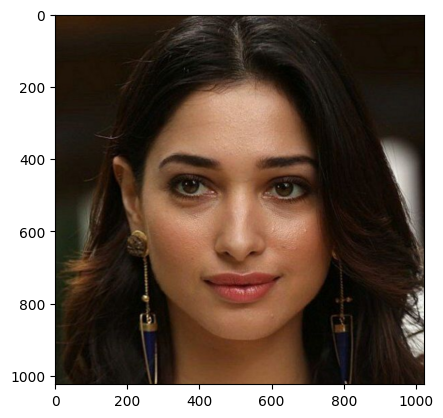

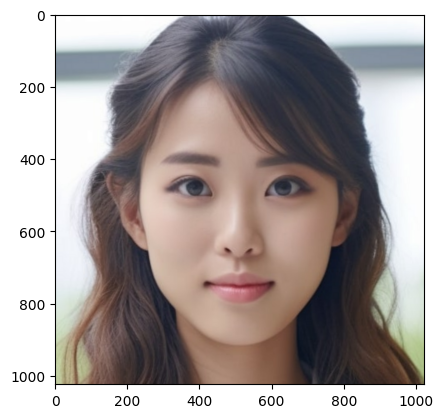

In [14]:
align_src = cv2.imread('inputs/align/src_0.png')
img = cv2.cvtColor(align_src, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

align_dst = cv2.imread('inputs/align/dst_0.png')
img = cv2.cvtColor(align_dst, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [15]:
NETWORK = "/home/kawa/AI/GitHub_public/StyleGAN3/ffhq-dataset/stylegan3-r-ffhq-1024x1024.pkl"

In [23]:
!python projector.py --save-video 0 --num-steps 1000 --outdir=outputs/src --target=inputs/align/src_0.png --network={NETWORK}
!python projector.py --save-video 0 --num-steps 1000 --outdir=outputs/dst --target=inputs/align/dst_0.png --network={NETWORK}

Loading networks from "/home/kawa/AI/GitHub_public/StyleGAN3/ffhq-dataset/stylegan3-r-ffhq-1024x1024.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
/home/kawa/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/1000: dist 0.64 loss 0.64 
step    2/1000: dist 0.58 loss 0.58 
step    3/1000: dist 0.61 loss 0.61 
step    4/1000: dist 0.58 loss 0.58 
step    5/1000: dist 0.68 loss 0.68 
step    6/1000: dist 0.54 loss 0.54 
step    7/1000: dist 0.56 loss 0.56 
step    8/1000: dist 0.53 loss 0.53 
step    9/1000: dist 0.65 loss 0.65 
step   10/1000: dist 0.59 loss 0.59 
step   11/1000: dist 0.59 loss 

In [43]:
!python projector.py --help

Usage: projector.py [OPTIONS]

  Project given image to the latent space of pretrained network pickle.
  Examples: python projector.py --outdir=out --target=~/mytargetimg.png \
  --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-
  pytorch/pretrained/ffhq.pkl

Options:
  --network TEXT        Network pickle filename  [required]
  --target FILE         Target image file to project to  [required]
  --num-steps INTEGER   Number of optimization steps  [default: 1000]
  --seed INTEGER        Random seed  [default: 303]
  --save-video BOOLEAN  Save an mp4 video of optimization progress  [default:
                        True]
  --outdir DIR          Where to save the output images  [required]
  --fps INTEGER         Frames per second of final video  [default: 30]
  --help                Show this message and exit.


Morphingを行う

In [24]:
STEPS = 5
FPS = 20
FREEZE_STEPS = 20

lvec1 = np.load('outputs/src/projected_w.npz')['w']
lvec2 = np.load('outputs/dst/projected_w.npz')['w']

device = torch.device('cuda')
with dnnlib.util.open_url(NETWORK) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('./movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1

  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

ここでは以下のエラーでビデオに書き込めない

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
/tmp/ipykernel_20298/3048533162.py in <module>
     22 
     23   for i in range(repeat):
---> 24     video.append_data(synth_image)
     25   current = current + step
     26 

~/.pyenv/versions/3.10.12/lib/python3.10/site-packages/imageio/core/format.py in append_data(self, im, meta)
    588             im = asarray(im)
    589             # Call
--> 590             return self._append_data(im, total_meta)
    591 
    592         def set_meta_data(self, meta):

~/.pyenv/versions/3.10.12/lib/python3.10/site-packages/imageio/plugins/ffmpeg.py in _append_data(self, im, meta)
    585                 self._size = size
    586                 self._depth = depth
--> 587                 self._initialize()
    588 
    589             # Check size of image

~/.pyenv/versions/3.10.12/lib/python3.10/site-packages/imageio/plugins/ffmpeg.py in _initialize(self)
    628 
...
--> 630             self._write_gen = self._ffmpeg_api.write_frames(
    631                 self._filename,
    632                 self._size,

TypeError: write_frames() got an unexpected keyword argument 'audio_path'

In [25]:
# morphing画像を保存する

lvec1 = np.load('outputs/src/projected_w.npz')['w']
lvec2 = np.load('outputs/dst/projected_w.npz')['w']

device = torch.device('cuda')
with dnnlib.util.open_url(NETWORK) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

for j in tqdm(range(STEPS)):
    z = torch.from_numpy(current).to(device)
    synth_image = G.synthesis(z, noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    # 画像を保存するパス
    output_path = 'outputs/movie/image'+str(j)+'.jpg'
    # synth_imageをOpenCVの形式に変換 (BGR形式)
    synth_image_cv = cv2.cvtColor(synth_image, cv2.COLOR_RGB2BGR)
    # OpenCVを使って画像を保存します
    cv2.imwrite(output_path, synth_image_cv)
    current = current + step

  0%|          | 0/5 [00:00<?, ?it/s]